In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import copy
import numpy as np
import time
import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_33960\2225627620.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# data import and preparing

In [55]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
data=data[:,1:]

dataNorm=data/np.max(data)

dataTen=torch.tensor(dataNorm).float()

train_loader=DataLoader(dataTen[:18000,:],batch_size=32,shuffle=True,drop_last=True)
test_loader=DataLoader(dataTen[18000:,:],batch_size=2000)

# occlusion sample:

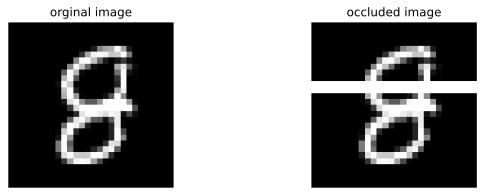

In [4]:
img=dataTen[11000,:].view(28,28).detach()

occluded=copy.deepcopy(img)
occluded[10:12,:]=1

fig,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('orginal image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('occluded image')
ax[1].axis('off')

plt.show()

# Neural network

In [16]:
def createModul():   
    class model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input=nn.Linear(784,150)
            
            self.enc=nn.Linear(150,50)
            self.latent=nn.Linear(50,150)
            self.dec=nn.Linear(150,784)
        
        def forward(self,x):
            x=F.relu(self.input(x))
            
            x=F.relu(self.enc(x))
            x=F.relu(self.latent(x))
            
            x=torch.sigmoid(self.dec(x))
            return x
        
    ann=model()
    
    lossfun=nn.MSELoss()
    
    optimizer=torch.optim.Adam(ann.parameters(),lr=.001)
    
    return ann,lossfun,optimizer

In [21]:
ann=createModul()[0]
dat=next(iter(test_loader))
result=ann(dat)
print(dat.shape)
print(result.shape)

torch.Size([1000, 784])
torch.Size([1000, 784])


# model training

In [23]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [25]:
def trainModel(numepoch=10):
    losses=torch.zeros(numepoch)
    
    ann,lossfun,optimizer=createModul()
    
    ann=ann.to(device)
    for epoch in range(numepoch):
        batchloss=[]
        for dat in train_loader:
            dat=dat.to(device)
            
            yHat=ann(dat)
            loss=lossfun(yHat,dat)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchloss.append(loss.item())
            
        losses[epoch]=np.mean(batchloss)
        
        msg='finished {}-epoch of training'.format(epoch)
        sys.stdout.write('\r'+msg)
        
    return ann,losses

Text(0.5, 0, 'Epoch')

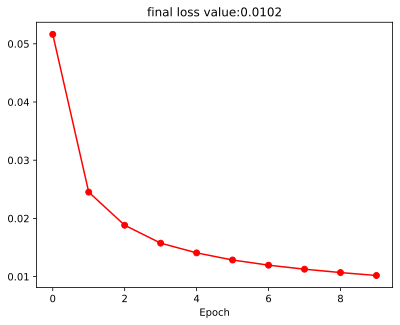

In [31]:
ann,losses=trainModel()
plt.plot(losses,'ro-')
plt.title(f'final loss value:{losses[-1]:.4f}')
plt.xlabel('Epoch')

# adding occlusion to test image

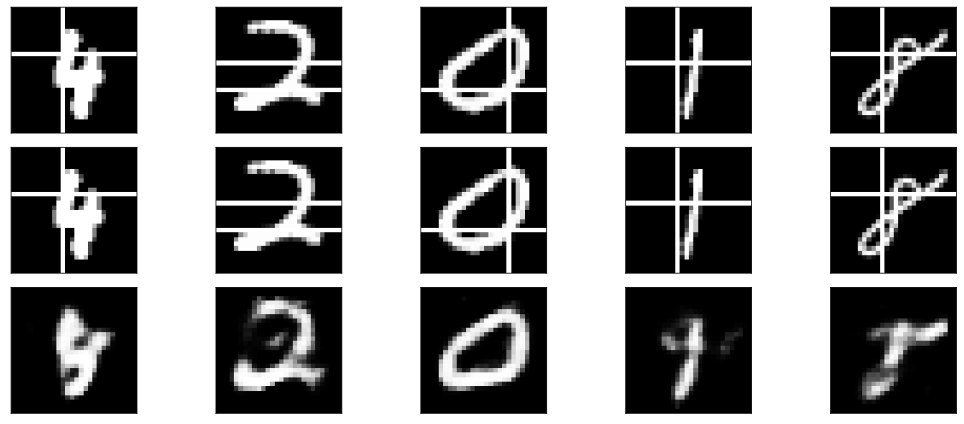

In [68]:
# test=copy.deepcopy(test_loader.dataset)
test=test_loader.dataset
for i in range(test.shape[0]):
    img=test[i,:].view(28,28)
    
    startLoc=np.random.choice(range(10,20))
    if startLoc%2==0:
        img[startLoc:startLoc+1,:]=1
    else:
        img[:,startLoc:startLoc+1]=1

test=test.to(device)
deoccluded=ann(test)

test=test.cpu()
deoccluded=deoccluded.cpu()

fig,ax=plt.subplots(3,5,figsize=(15,6))
randNum=np.random.randint(test.shape[0],size=5)
for i in range(5):
    ax[0,i].imshow(test_loader.dataset[randNum[i],:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(test[randNum[i],:].view(28,28).detach(),cmap='gray')
    ax[2,i].imshow(deoccluded[randNum[i],:].view(28,28).detach(),cmap='gray')
    ax[0,i].set_xticks([]),ax[0,i].set_yticks([])
    ax[1,i].set_xticks([]),ax[1,i].set_yticks([])
    ax[2,i].set_xticks([]),ax[2,i].set_yticks([])

plt.tight_layout()
plt.show()

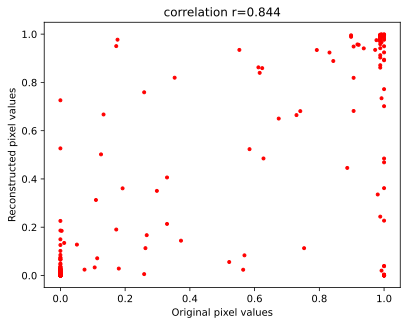

In [67]:
perCorr=np.corrcoef(test_loader.dataset[200,:].detach(),deoccluded[200,:].detach())

plt.plot(test_loader.dataset[200,:].detach(),deoccluded[200,:].detach(),'r.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'correlation r={perCorr[0,1]:.3f}')
plt.show()